GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.5 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

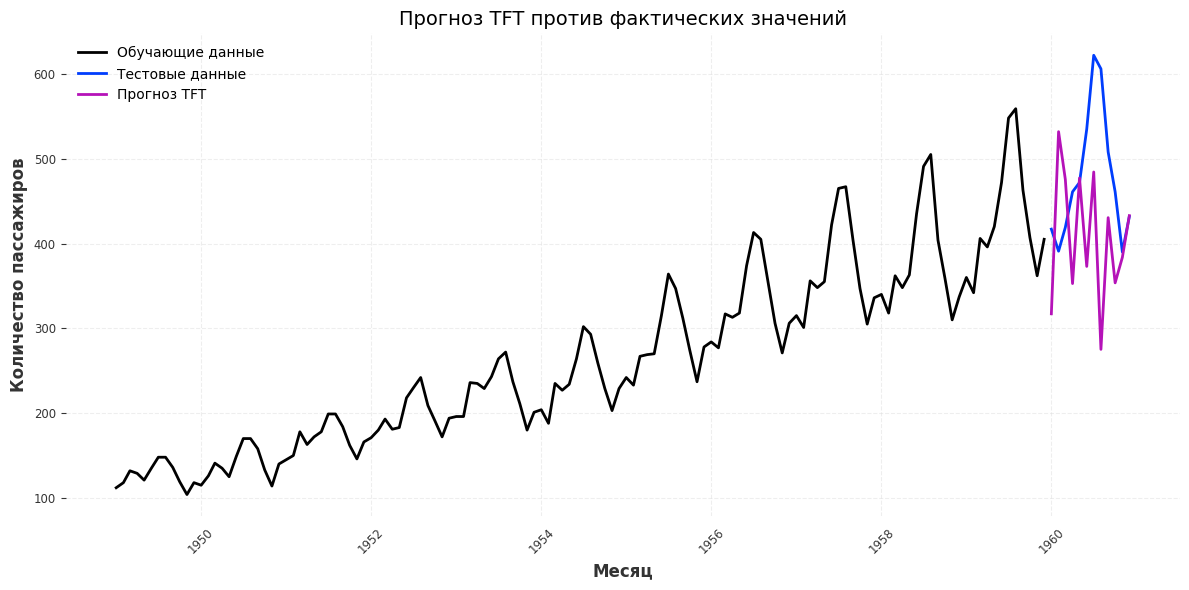

Среднеквадратичная ошибка TFT: 134.46


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import mean_squared_error

# Загрузка данных
data = pd.read_csv('AirPassengers.csv')  # Замените на путь к вашему файлу
data["Month"] = pd.to_datetime(data["Month"]).dt.to_period("M").dt.to_timestamp()

# Определяем последний год для тестовой выборки
last_year = data["Month"].dt.year.max()

# Разделение данных: тренировочные и тестовые
train_data = data[data["Month"].dt.year < last_year]
test_data = data[data["Month"].dt.year == last_year]

# Подготовка временного ряда для Darts
train_series = TimeSeries.from_dataframe(train_data, time_col='Month', value_cols='#Passengers')
test_series = TimeSeries.from_dataframe(test_data, time_col='Month', value_cols='#Passengers')

# Масштабирование тренировочных данных
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train_series)

# Инициализация модели TFT
tft_model = TFTModel(
    input_chunk_length=12,     # Длина входного окна данных для обучения модели
    output_chunk_length=12,    # Длина окна для прогнозирования
    hidden_size=64,            # Размер скрытого слоя
    n_epochs=30,               # Количество эпох обучения
    dropout=0.2,               # Дроп-аут для регуляризации
    add_relative_index=True     # Автоматическая генерация будущих ковариат
)

# Обучение модели
tft_model.fit(scaled_train)

# Прогнозирование на 12 месяцев вперед
forecast = tft_model.predict(n=12)

# Обратное преобразование для получения оригинальных значений
forecast = train_scaler.inverse_transform(forecast)

# Визуализация результатов
plt.figure(figsize=(12, 6))
train_series.plot(label='Обучающие данные', lw=2)
test_series.plot(label='Тестовые данные', lw=2)
forecast.plot(label='Прогноз TFT', lw=2)

# Добавление заголовка и подписей к осям
plt.title("Прогноз TFT против фактических значений", fontsize=14)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("Количество пассажиров", fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()

# Вычисление RMSE для TFT
tft_rmse = np.sqrt(mean_squared_error(test_data["#Passengers"], forecast.values()))
print(f"Среднеквадратичная ошибка TFT: {tft_rmse:.2f}")
